In [1]:
# !pip install imutils

In [1]:
import numpy as np
import cv2
import tensorflow as tf
import os
from imutils import paths
%matplotlib inline
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
from random import shuffle
from glob import glob

IMG_SIZE = (224, 224)  # размер входного изображения сети

# train_files = glob('hymenoptera_data/train/*.jpg')
# test_files = glob('hymenoptera_data/val/*.jpg')

train_files = glob('hymenoptera_data/train/ants/*.jpg') + glob('hymenoptera_data/train/bees/*.jpg')
test_files = glob('hymenoptera_data/val/ants/*.jpg') + glob('hymenoptera_data/val/bees/*.jpg')

# загружаем входное изображение и предобрабатываем
def load_image(path, target_size=IMG_SIZE):
    img = cv2.imread(path)[...,::-1]
    img = cv2.resize(img, target_size)
#     return vgg16.preprocess_input(img)  # предобработка для VGG16
#     return tf.keras.applications.resnet.preprocess_input(img, data_format=None)
    return tf.keras.applications.resnet.preprocess_input(img)

# функция-генератор загрузки обучающих данных с диска
def fit_generator(files, batch_size=32):
    batch_size = min(batch_size, len(files))
    while True:
        shuffle(files)
        for k in range(len(files) // batch_size):
            i = k * batch_size
            j = i + batch_size
            if j > len(files):
                j = - j % len(files)
            x = np.array([load_image(path) for path in files[i:j]])
#             y = np.array([1. if os.path.basename(path).startswith('dog') else 0.
#                           for path in files[i:j]])
            y = np.array([1 if 'bees' in os.path.dirname(path) else 0.
                          for path in files[i:j]])
            yield (x, y)

# функция-генератор загрузки тестовых изображений с диска
def predict_generator(files):
    while True:
        for path in files:
            yield np.array([load_image(path)])



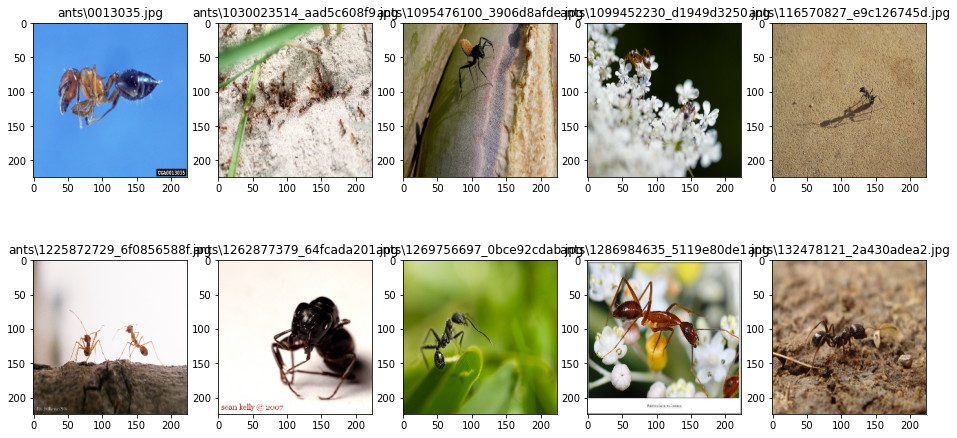

In [3]:
%matplotlib inline
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(16, 8))
for i, path in enumerate(train_files[:10], 1):
    subplot = fig.add_subplot(2, 5, i)
    subplot.set_title('%s' % path.split('/')[-1])
    img = cv2.imread(path)[...,::-1]
    img = cv2.resize(img, IMG_SIZE)
    plt.imshow(img)

In [4]:
model_1 = tf.keras.applications.ResNet50(
    include_top=True,
    weights=None,
    input_tensor=None,
    input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3),
#     input_shape=(3, IMG_SIZE[0], IMG_SIZE[1]),
    pooling=None,
    classes=1
#     **kwargs
)

In [5]:
model_1.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [6]:
epochs = 10

# callbacks = [
#     keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
# ]
model_1.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)


In [7]:
val_samples = 5  # число изображений в валидационной выборке
shuffle(train_files)  # перемешиваем обучающую выборку
validation_data = next(fit_generator(train_files[:val_samples], val_samples))
train_data = fit_generator(train_files[val_samples:])  # данные читаем функцией-генератором

In [8]:
# запускаем процесс обучения
model_1.fit(train_data,
          steps_per_epoch=10,  # число вызовов генератора за эпоху
          epochs=10,  # число эпох обучения
          validation_data=validation_data)

Epoch 1/10
10/10 [==============================] - 167s 16s/step - loss: 2.8585 - accuracy: 0.4580 - val_loss: 5776.1870 - val_accuracy: 1.0000
Epoch 2/10
10/10 [==============================] - 151s 15s/step - loss: 0.7254 - accuracy: 0.4704 - val_loss: 36441.4141 - val_accuracy: 1.0000
Epoch 3/10
10/10 [==============================] - 176s 18s/step - loss: 0.5841 - accuracy: 0.4782 - val_loss: 8422.9785 - val_accuracy: 1.0000
Epoch 4/10
10/10 [==============================] - 176s 18s/step - loss: 0.5660 - accuracy: 0.5128 - val_loss: 2743.2922 - val_accuracy: 1.0000
Epoch 5/10
10/10 [==============================] - 182s 18s/step - loss: 0.5107 - accuracy: 0.4974 - val_loss: 113.1349 - val_accuracy: 1.0000
Epoch 6/10
10/10 [==============================] - 161s 16s/step - loss: 0.3994 - accuracy: 0.5058 - val_loss: 79.9925 - val_accuracy: 1.0000
Epoch 7/10
10/10 [==============================] - 165s 17s/step - loss: 0.3764 - accuracy: 0.4886 - val_loss: 13.0140 - val_accura

In [18]:
# validation_data[1]

In [29]:
test_data = fit_generator(test_files) 

In [32]:
scores_1 = model_1.evaluate(test_data, verbose=1, steps=len(test_files))
print("Test loss:", scores_1[0])
print("Test accuracy:", scores_1[1])

153/153 [==============================] - 354s 2s/step - loss: 8.1288 - accuracy: 0.5411
Test loss: 8.128844261169434
Test accuracy: 0.5410539507865906


In [24]:
# predictions_1 = model_1.predict(predict_generator(test_files))
# score_1 = predictions_1[0]
# print(
#     "This image is %.2f percent cat and %.2f percent dog."
#     % (100 * (1 - score), 100 * score)
# )

In [33]:
test_pred = model_1.predict(
    predict_generator(test_files), steps=len(test_files))

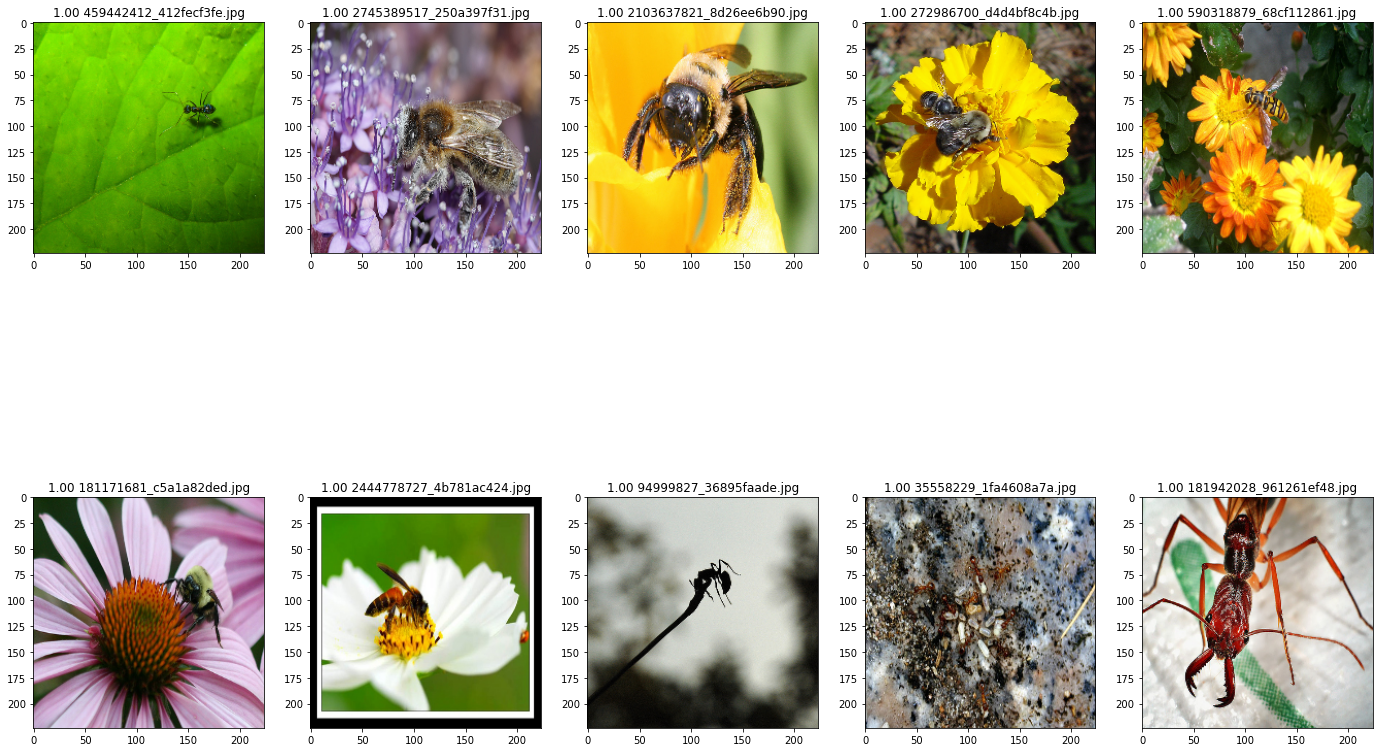

In [34]:
fig = plt.figure(figsize=(24, 16))
for i, (path, score) in enumerate(zip(test_files[:10], test_pred[:10]), 1):
    subplot = fig.add_subplot(2, 5, i)
    subplot.set_title('%.2f %s' % (score, os.path.basename(path)))
    img = cv2.imread(path)[...,::-1]
    img = cv2.resize(img, IMG_SIZE)
    subplot.imshow(img)

In [36]:
base_model = tf.keras.applications.ResNet50(
    include_top=False,
    weights="imagenet",
#     input_tensor=None,
    input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3),
#     pooling=None,
#     classes=1
#     **kwargs
)

In [37]:
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [38]:
# фиксируем все веса предобученной сети
for layer in base_model.layers:
    layer.trainable = False

x = base_model.layers[-5].output
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(1,  # один выход (бинарная классификация)
                          activation='sigmoid',  # функция активации  
                          kernel_regularizer=tf.keras.regularizers.l1(1e-4))(x)

model_2 = tf.keras.Model(inputs=base_model.input, outputs=x, name='ants_vs_bees')

In [39]:
model_2.summary()

Model: "ants_vs_bees"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
_______________________________________________________________________________________

In [41]:
model_2.compile(optimizer='adam', 
              loss='binary_crossentropy',  # функция потерь binary_crossentropy (log loss
              metrics=['accuracy'])

In [92]:
# # epochs = 10

# # callbacks = [
# #     keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
# # ]
# model_2.compile(
#     optimizer=keras.optimizers.Adam(1e-3),
#     loss="binary_crossentropy",
#     metrics=["accuracy"],
# )


In [42]:
# запускаем процесс обучения
model_2.fit(train_data,
          steps_per_epoch=10,  # число вызовов генератора за эпоху
          epochs=10,  # число эпох обучения
          validation_data=validation_data)

Epoch 1/10
10/10 [==============================] - 26s 2s/step - loss: 0.6948 - accuracy: 0.5571 - val_loss: 0.1435 - val_accuracy: 1.0000
Epoch 2/10
10/10 [==============================] - 21s 2s/step - loss: 0.1668 - accuracy: 0.9669 - val_loss: 0.1713 - val_accuracy: 1.0000
Epoch 3/10
10/10 [==============================] - 22s 2s/step - loss: 0.0911 - accuracy: 0.9854 - val_loss: 0.0929 - val_accuracy: 1.0000
Epoch 4/10
10/10 [==============================] - 23s 2s/step - loss: 0.0616 - accuracy: 1.0000 - val_loss: 0.0952 - val_accuracy: 1.0000
Epoch 5/10
10/10 [==============================] - 23s 2s/step - loss: 0.0381 - accuracy: 1.0000 - val_loss: 0.1019 - val_accuracy: 1.0000
Epoch 6/10
10/10 [==============================] - 23s 2s/step - loss: 0.0373 - accuracy: 1.0000 - val_loss: 0.0885 - val_accuracy: 1.0000
Epoch 7/10
10/10 [==============================] - 23s 2s/step - loss: 0.0338 - accuracy: 1.0000 - val_loss: 0.0805 - val_accuracy: 1.0000
Epoch 8/10
10/10 [==

In [43]:
scores_2 = model_2.evaluate(test_data, verbose=1, steps=len(test_files))
print("Test loss:", scores_2[0])
print("Test accuracy:", scores_2[1])

153/153 [==============================] - 346s 2s/step - loss: 0.2086 - accuracy: 0.9328
Test loss: 0.20857079327106476
Test accuracy: 0.9328022599220276


In [44]:
test_pred_2 = model_2.predict(
    predict_generator(test_files), steps=len(test_files))

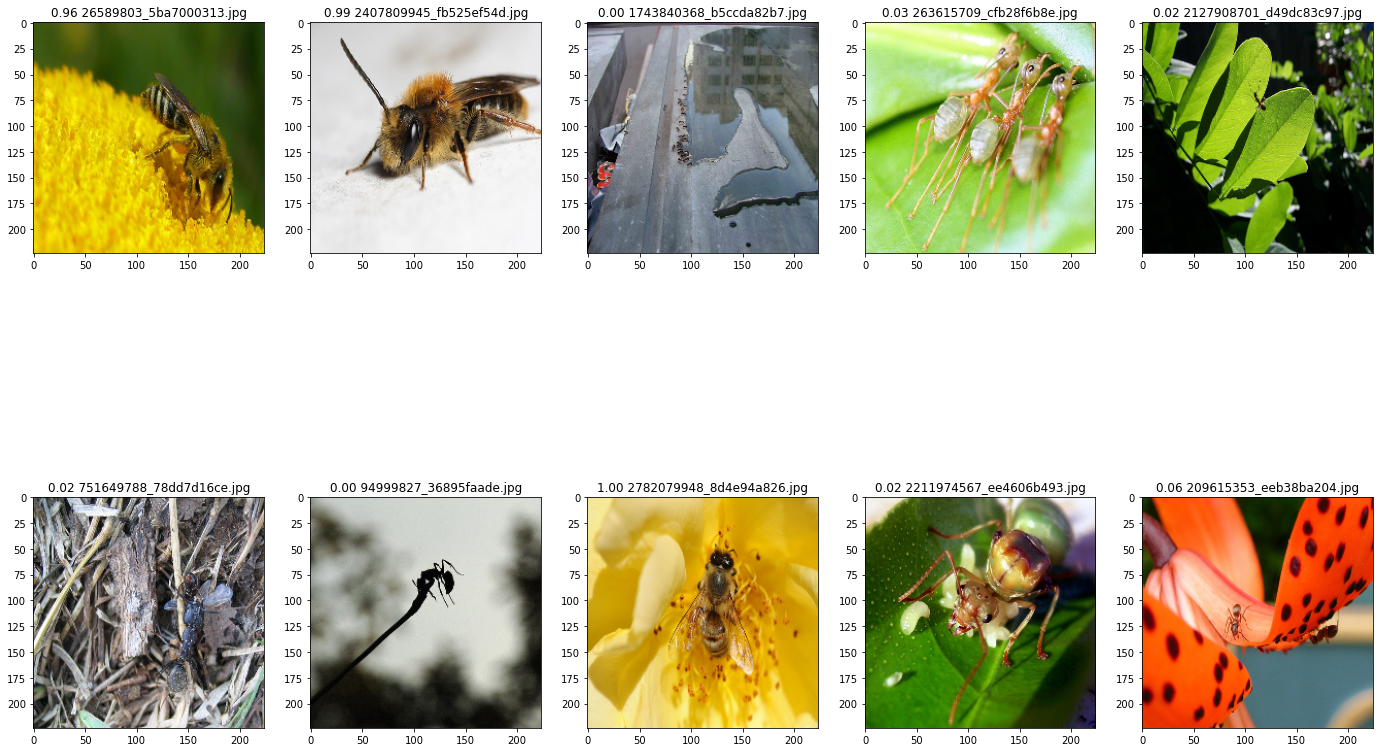

In [46]:
fig = plt.figure(figsize=(24, 16))
for i, (path, score) in enumerate(zip(test_files[:10], test_pred_2[:10]), 1):
    subplot = fig.add_subplot(2, 5, i)
    subplot.set_title('%.2f %s' % (score, os.path.basename(path)))
    img = cv2.imread(path)[...,::-1]
    img = cv2.resize(img, IMG_SIZE)
    subplot.imshow(img)